In [48]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
import sys
import ast
import seaborn as sns 
import pycountry_convert as pc
import pycountry
import geopandas as gpd
import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from geotext import GeoText
import datetime
import pickle
import nltk
from tqdm import tqdm
import spacy
import en_core_web_sm
from spacy.matcher import PhraseMatcher

In [2]:
df = pd.read_csv( '../../Projet/globalterrorismdb_0718dist.csv', encoding='ISO-8859-1' )

/Users/camilleelleaume/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Column content

Here some useful information about the principals columns in the Global Terrorism Data Base

- eventid: A 12-digit Event ID system. First 8 numbers – date recorded “yyyymmdd”. Last 4 numbers – sequential case number for the given day (0001, 0002 etc).
- doubtterr, we dropped values that were not sure to be a terror attack.
- attacktype1, attacktype2, attacktype3: The general method of attack
- attacktype1_txt, attacktype2_txt, attacktype3_txt: The general method of attack and broad class of tactics used. 1= assassination, 2=hijacking, 3= kidnapping 4=barricade 5=bombing/explosion, 6=armed assault, t=unarmed assault, 8=facility&infrastructure attack, 9=unknown
- gname, gname2, gname3: The name of the group that carried out the attack
- claimed (1= claimed, 0=no claim), claim2, claim3
- weaptype1, weaptype2, weaptype3, weaptype4 (type of weapon used)
- weaptype1_txt, weaptype2_txt, weaptype3_txt, weaptype4_txt: General type of weapon used in the incident
- nkill: The number of total confirmed fatalities for the incident (including also perpetrators)
- nkillus: The number of U.S. citizens who died as a result of the incident
- nkillter: number of killed terrorists
- nwound: number of wounded
- property if property was damaged
- propextent (1= more than 1 billion dollars, 2=1million-1biollion dollars 3= minor less than 1 million, 4 unknown)
- propvalue numerical value of property dammage

## Load Data and cleaning

In [3]:
# cleaning the dates and creating a date column
df=df.rename(columns={'iday' : 'day','imonth' : 'month','iyear': 'year'})
df=df.set_index('eventid')

In [4]:
#creating a copy of df where all duplicates are dropped (duplicates compared over all columns)
df_approx=df.drop_duplicates(keep='first')

We will now merge the columns with the same type of content, we will have now instead claimed, claim2, claim3 a list of claims in a column named after the first repetition instance. 

In [5]:
# merging of columns
col_names = df_approx.columns.values.tolist()
d = {}

def add(mask, s):
    if mask not in d:
        d[mask] = []
    d[mask].append(s)
    
# keep in a dict the similar column names as lists with as keys the shared similar name    
for s in col_names:
    for pos in range(len(s)):
        add(s[:pos] + '?' + s[pos + 1:], s)
        add(s[:pos] + '?' + s[pos:], s)
    add(s + '?', s)
    
# for similar column names in the dict merge the content of the columns as list and drop the additional columns
for k, v in d.items():
    if len(v) > 1:
        df_approx[v[0]] = df_approx[v].values.tolist()
        df_approx[v[0]] = df_approx[v[0]].apply(lambda x: [i for i in x if i == i])
        df_approx = df_approx.drop(columns=v[1:])
df_approx.shape

/Users/camilleelleaume/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/camilleelleaume/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(177140, 87)

## To be (a terrorist) or not to be? GTD Definition of Terrorism and Inclusion Criteria

The GTD defines a terrorist attack as the threatened or actual use of illegal force and violence by
a non-state actor to attain a political, economic, religious, or social goal through fear, coercion,
or intimidation. In practice this means in order to consider an incident for inclusion in the GTD,
all three of the following attributes must be present:
* The incident must be intentional – the result of a conscious calculation on the part of a perpetrator.
* The incident must entail some level of violence or immediate threat of violence -including property violence, as well as violence against people.
* The perpetrators of the incidents must be sub-national actors. The database does not include acts of state terrorism.

In addition, at least two of the following three criteria must be present for an incident to be
included in the GTD:
**criterion1** The act must be aimed at attaining a political, economic, religious, or social goal. In terms of economic goals, the exclusive pursuit of profit does not satisfy this criterion. It must involve the pursuit of more profound, systemic economic change.

**criterion2** here must be evidence of an intention to coerce, intimidate, or convey some other message to a larger audience (or audiences) than the immediate victims. It is the act taken as a totality that is considered, irrespective if every individual involved in carrying out the act was aware of this intention. As long as any of the planners or decision-makers behind the attack intended to coerce, intimidate or publicize, the intentionality criterion is met.

**criterion3**The action must be outside the context of legitimate warfare activities. That is, the act must be outside the parameters permitted by international humanitarian law, insofar as it targets non-combatants

In [6]:
#only keep the attacks which are sure to be considered as terrorist attacks according to mention above
#leaves us with a 135554 attacks in all
print('the number of entries which are sure to be terror attacks using the doubtterr variable equal to 0:', len(df_approx.loc[df_approx.doubtterr==0]))

print('the number of entries which fulfill all 3 criteria', len(df_approx.loc[(df_approx.crit1.apply(lambda x: sum(x))==3)]))
print('the number of entries which fulfill at leaset 2 criteria', len(df_approx.loc[(df_approx.crit1.apply(lambda x: sum(x))>=2)]))

#as all attacks fill at least two of the criteria mentioned above, they are all considered terrorist attacks.
print('the number of entries that fulfill less than 2 criteria, and are therefore for sure not terrorist attacks: ',len(df_approx.loc[(df_approx.crit1.apply(lambda x: sum(x))<2)]))

the number of entries which are sure to be terror attacks using the doubtterr variable equal to 0: 135554
the number of entries which fulfill all 3 criteria 151512
the number of entries which fulfill at leaset 2 criteria 177140
the number of entries that fulfill less than 2 criteria, and are therefore for sure not terrorist attacks:  0


In [7]:
print('the length of the full dataset: ', len(df_approx))

the length of the full dataset:  177140


This justifies that we do not drop data solely based on the "doubtterr" variable being equal to 0. all entries that we have are considered to be terrorist attacks according to the definition above.

## Clean year feature

In [8]:
df_approx=df_approx.drop(columns=['summary','gsubname','compclaim',\
                        'propcomment','ransomamt','addnotes','scite1',\
                        'dbsource','divert','kidhijcountry','alternative','alternative_txt'])

In [9]:
df_approx.head()

,year,month,day,approxdate,extended,resolution,country,country_txt,region,region_txt,...,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
eventid,,,,,,,,,,,,,,,,,,,,,
1.970000e+11,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN
1.970000e+11,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,...,NaN,NaN,NaN,NaN,NaN,0,1,1,1,NaN
1.970010e+11,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,...,NaN,NaN,NaN,NaN,NaN,-9,-9,1,1,NaN
1.970010e+11,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,...,NaN,NaN,NaN,NaN,NaN,-9,-9,1,1,NaN
1.970010e+11,1970,1,0,NaN,0,NaN,101,Japan,4,East Asia,...,NaN,NaN,NaN,NaN,NaN,-9,-9,1,1,NaN


In [2]:
#where day month and year are properly filled in, a date-type is created and stored in a new column "date"
df_approx['date']=pd.to_datetime(df_approx[['day','month','year']], exact=False, errors = 'coerce')

#Clean dates with "/" inside the approx date
#get approxdates where there is no proper "date" and the approxdate is inferior to a len of 12 characters
#the dates are in the following format month/day/year ../../..
df_approx['approxdate']=df_approx['approxdate'].where(df_approx.loc[df_approx['date'].isna()]['approxdate'].str.len()<12)

#where there is a "/" within the approxdate, modify to a datetime and stock as date
pd.to_datetime(df_approx.loc[df_approx['approxdate'].str.contains('/',na=False)]['approxdate'])
df_approx['date']=df_approx['date'].combine_first(df_approx['approxdate'])

# if the attack takes place over multiple days transform the resolution date into a date object
df_approx['resolution']=pd.to_datetime(df_approx.resolution, exact=False, errors = 'coerce')

#addition of a span column for the attacks where there is a start date and resolution date
df_approx['span']=df_approx['resolution']-df_approx['date']

Clean data has been saved in pickle file 

In [3]:
import pickle
pickle_in = open("../../Projet/df_approx.pkl","rb")
df_approx = pickle.load(pickle_in)

## Number of terrorist attacks across years

Text(0.5, 1.0, 'count of terror attacks per year')

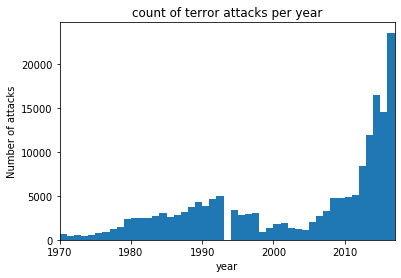

In [4]:
f= plt.hist(df_approx['year'], bins=47)
plt.xlim(df_approx.year.min(), df_approx.year.max())
plt.xlabel('year')
plt.ylabel('Number of attacks')
plt.title('count of terror attacks per year')
#TODO add a fucking y label

Looking over the years from 1970 to 2017, we can see an increase of incidents, especially in recent years starting around 2010.
There is a strange gap in the data in 1993. Looking into terror attacks in 1993, we can clearly see that it is not that no attacks happened during this year (ex, attack on worldtrade center on February 23 1993 https://www.state.gov/1993-world-trade-center-bombing/) Reading into the information on the dataset, we found that the data was lost prior to addition to the dataset. This explanes the gap observed. 
(https://www.start.umd.edu/gtd/downloads/Codebook.pdf)



### Link of human casualties with an increase in terrorist attacks
We observed before that there is a clear increase of the number of terrorist attacks over the more recent years. What does this imply for the general population? Are there more casualties as the number of attacks increase? Are the extent of the attacks constant, or are there more "small" attacks over the recent years? 

Do all attacks result in injured victims? If not, what is the percentage of attacks which result in the death or wounded victims ?

In [5]:
df_approx['nkillvi'] = df_approx['nkill'] - df_approx['nkillter'] 
df_approx['nwoundvi'] = df_approx['nwound'] - df_approx['nwoundte'] 

In [6]:
#number of cases in which victims were killed
killed_victims=(df_approx.nkill.dropna()>0).value_counts()

Text(0.5, 1.0, 'attacks resulting in death')

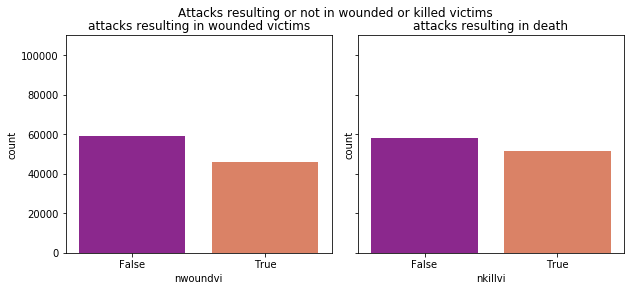

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (10,4), sharey=True)
fig.suptitle('Attacks resulting or not in wounded or killed victims')
plt.gcf().subplots_adjust(wspace = 0.1)

fig=sns.countplot(df_approx.nwoundvi.dropna()>0, palette='plasma', ax=ax1)
fig=sns.countplot(df_approx.nkillvi.dropna()>0,palette='plasma', ax=ax2)

ax1.set_ylim(0,110000)
ax1.set_title('attacks resulting in wounded victims')
ax2.set_ylim(0,110000)
ax2.set_title('attacks resulting in death')

looking into the amount of attacks that result in victims dying, we can see that it is about the same amount of attacks which don't resuslt in death as to the ones which do. Doing the same with the amount of attacks resulting in wounded victims, we can clearly see that there are more attacks which don't result in wounded victims than attacks which do. This could be a surprising result, seeing that many terrorist attacks do not concretely result in human casualties. This way of looking at it however is purely binary, meaning that the amount of wounded or dead is not taken into consideration. It might also be interesting to identify if the attacks which did not result in any human casualties, are considered as a "successful" attack or not. 

In [8]:
(df_approx.nwoundvi.dropna()>0).value_counts()

False    59185
True     45783
Name: nwoundvi, dtype: int64

In [9]:
#creation of casualties dataframe
df_casualties=pd.DataFrame(index=df_approx.year.unique())
df_casualties=df_casualties.sort_index(ascending=True)
df_casualties['killed']=df_approx.groupby('year')['nkillvi'].agg('sum')
df_casualties['wounded']=df_approx.groupby('year')['nwoundvi'].agg('sum')
#df_casualties['killpattack']=df_casualties['killpyear']/df_approx.year.value_counts()
#df_casualties['woundpattack']=df_casualties['woundpyear']/df_approx.year.value_counts()

Text(0, 0.5, 'human casualties')

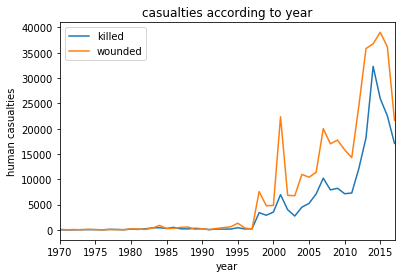

In [10]:
fig=df_casualties.plot(title='casualties according to year')
fig.set_xlabel('year')
fig.set_xticks(np.arange(1970, 2017, step=5))
fig.set_ylabel('human casualties')

The amount of wounded follows the amount of killed victims quite closely. Interestingly in the early 2000s there is a high peak of wounded, and we hypothesize that this is due to the extent of the terrorist attack on the worldtrade center in 2001. Further analysis will be required to confirm this hypothesis however. 
We have also seen that the number of terror attacks continue to increase up to 2017, however here, it seems that the amount of human casualties decreases. Are the terror attacks touching less people? What could this decrease be do to? 

We will now also look into the average number of casualties per attack over the years

In [11]:
df_casualties_av=pd.DataFrame(index=df_approx.year.unique())
df_casualties_av=df_casualties_av.sort_index(ascending=True)
#df_casualties['killed']=df_approx.groupby('year')['nkill'].agg('sum')
#df_casualties['wounded']=df_approx.groupby('year')['nwound'].agg('sum')
df_casualties_av['av killed (per attack)']=df_casualties['killed']/df_approx.year.value_counts()
df_casualties_av['av wounded (per attack)']=df_casualties['wounded']/df_approx.year.value_counts()

Text(0, 0.5, 'human casualties')

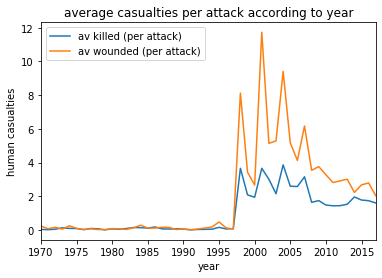

In [12]:
fig=df_casualties_av.plot(title='average casualties per attack according to year')
fig.set_xlabel('year')
fig.set_xticks(np.arange(1970, 2017, step=5))
fig.set_ylabel('human casualties')

observing the average number of casualties (both wounded and killed) due to attacks, we can tell that around 2000, there were peaks of years where there were a larger number of people touched per incident than the other years. This could follow the hypothesis evoqued in the point before, that there may be a few larger attacks which happened during this period (ex, 9.11.2001), which bring the number of casualties of that year, up significantly, eventhough there were not more attacks per se.  

### Link of propreties dammages with an increase in terrorist attacks

We can also measure the impact of an attack based on the value of the damaged propreties. An attack may have destroyed important public buildings without dead or wounded for example.

[Text(0.5, 0, 'year')]

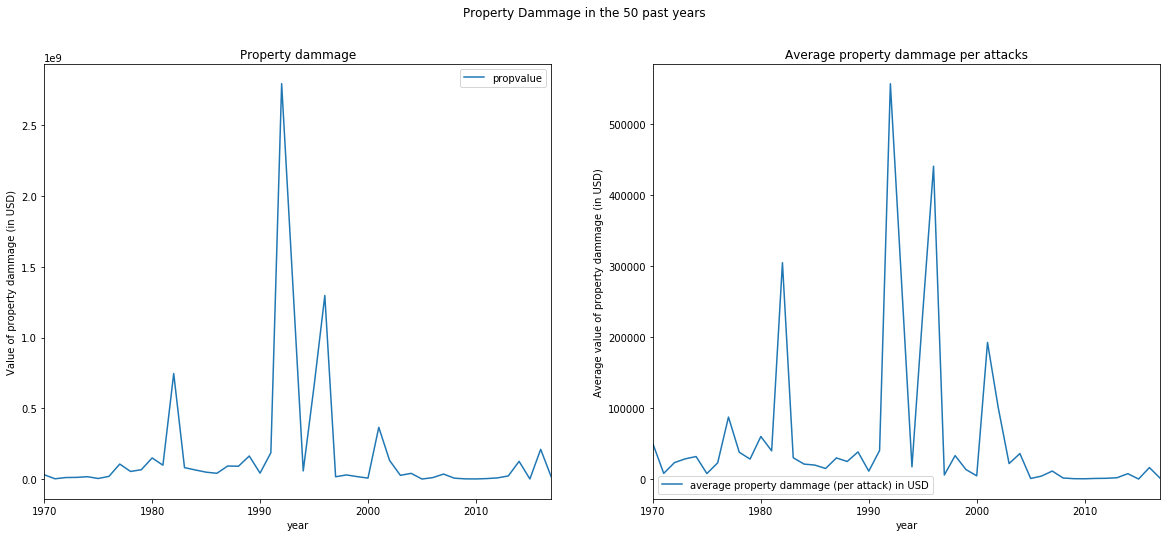

In [13]:
#creation of propriety value dataframe
df_propvalue=pd.DataFrame(index=df_approx.year.unique())
df_propvalue=df_propvalue.sort_index(ascending=True)
df_propvalue['propvalue']=df_approx.groupby('year')['propvalue'].agg('sum')

df_propvalue_av=pd.DataFrame(index=df_approx.year.unique())
df_propvalue_av=df_propvalue_av.sort_index()
df_propvalue_av['average property dammage (per attack) in USD']=df_propvalue['propvalue']/ \
                                                                    df_approx.year.value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (20,8))
fig.suptitle('Property Dammage in the 50 past years')
plt.gcf().subplots_adjust(wspace = 0.2)

df_propvalue.plot(title='Property dammage', ax= ax1)
df_propvalue_av.plot(title='Average property dammage per attacks', ax= ax2)
ax1.set_ylabel('Value of property dammage (in USD)')
ax2.set_ylabel('Average value of property dammage (in USD)')
ax1.set(xlabel='year')
ax2.set(xlabel='year')

There is no increase over the years for property damage. Standardization by number of attacks per year does not show much difference because the number of attacks is not increasing sufficiently significantly in those years (see above).
However we observe several years showing a peak in the value of damaged properties. It may be interesting later to explore what attacks caused this increase and where they occurred.

## What about location?

In [14]:
df_temp=df_approx
df_temp=df_temp.groupby(['year','region_txt']).size()

In [15]:
# Unsstack the outer index
dfa=df_temp.unstack(level=1)
df1 = dfa[dfa.columns[range(6)]]
df2=dfa.iloc[:,-6:]

[Text(0.5, 0, 'year')]

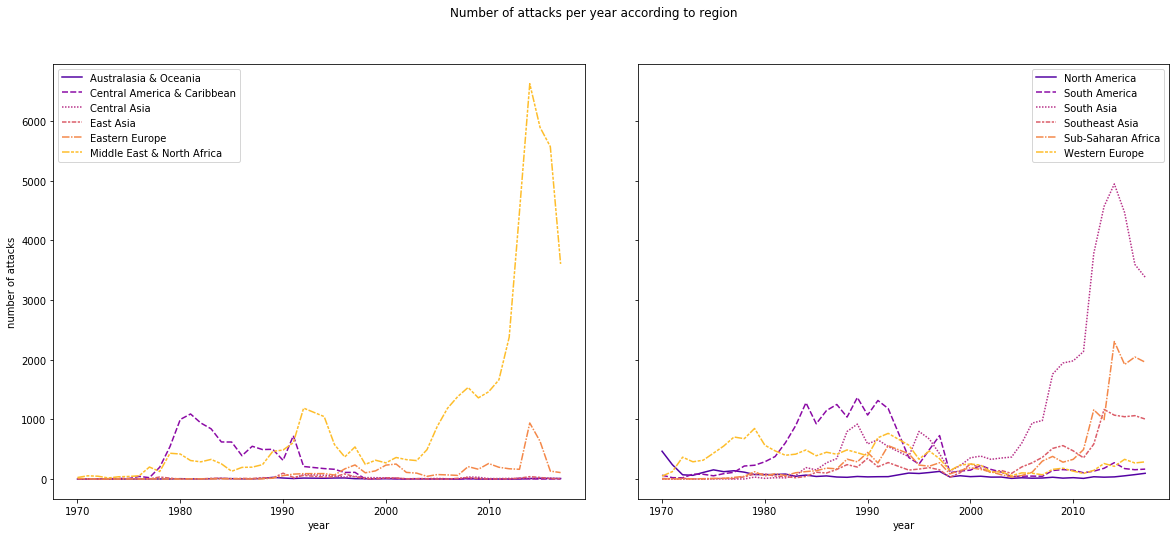

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (20,8), sharey=True)
fig.suptitle('Number of attacks per year according to region')
plt.gcf().subplots_adjust(wspace = 0.1)

sns.lineplot(data=df1,palette='plasma', ax= ax1)
ax1.set(xlabel='year', ylabel='number of attacks')

sns.lineplot(data=df2, palette='plasma', ax= ax2)
ax2.set(xlabel='year')

In [17]:
df_temp=df_approx
df_temp=df_temp.groupby(['year','region_txt']).agg({'nkillvi': 'sum'})

# Unsstack the outer index
dfa = df_temp.unstack(level=1)
dfa.columns = dfa.columns.droplevel()
df1 = dfa[dfa.columns[range(6)]]
df2= dfa.iloc[:,-6:]

[Text(0.5, 0, 'year')]

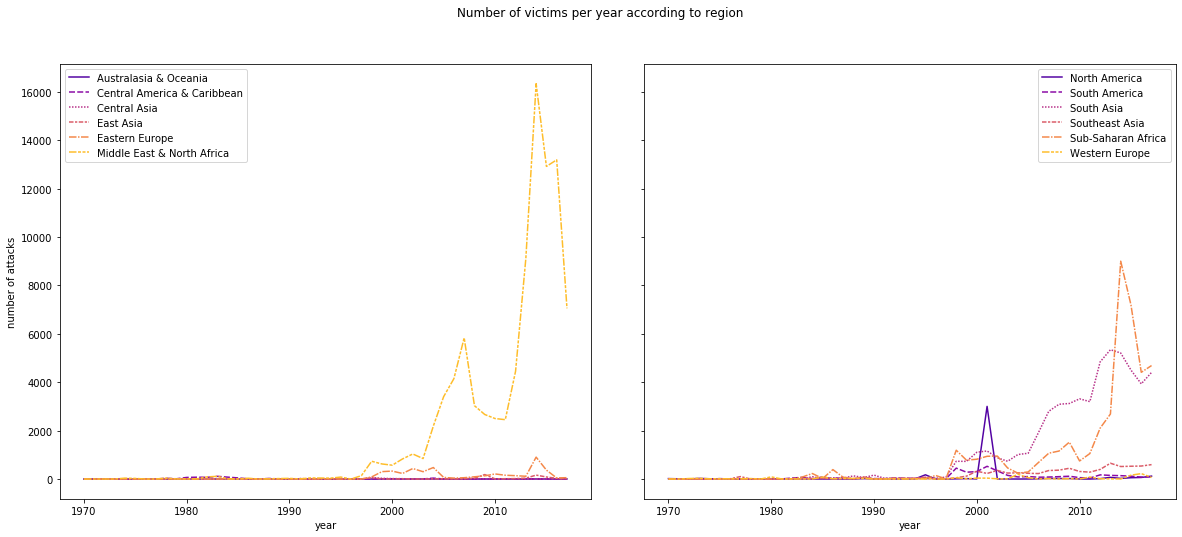

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (20,8), sharey=True)
fig.suptitle('Number of victims per year according to region')
plt.gcf().subplots_adjust(wspace = 0.1)

sns.lineplot(data=df1,palette='plasma', ax= ax1)
ax1.set(xlabel='year', ylabel='number of attacks')

sns.lineplot(data=df2, palette='plasma', ax= ax2)
ax2.set(xlabel='year')


### Getting an overall idea as to numbers of casualties in the past 50 years per region

In [19]:
df_temp2=df_approx
df_temp2.groupby('region_txt')['nkillvi'].agg('sum').sort_values(ascending = False)

region_txt
Middle East & North Africa     94677.0
South Asia                     53950.0
Sub-Saharan Africa             43107.0
Southeast Asia                  7476.0
Eastern Europe                  4554.0
South America                   3997.0
North America                   3793.0
Western Europe                  1374.0
East Asia                        671.0
Central America & Caribbean      643.0
Central Asia                     276.0
Australasia & Oceania             14.0
Name: nkillvi, dtype: float64

Middle East and North Africa, South Asia and Sub-sahran Africa clearly deplore more deaths than other regions of the world. 

On the other hand, Australasia and Oceania recorded only 14 deaths. Is there significantly less deaths in Oceania ? We can see that, indeed the curve of that area is really flat compared to other regions on the graphs above.

Central Asia or Central America refer relatively few deaths as rather considered dangerous areas of the globe. It can be explained because the different events in these areas will be considered as conflicts due to wars or guerrilla rather than as terrorist attacks.

### Visualization of number of attacks and number of victims per country 

Let's consider each country independently.
For what follows, we only consider the attacks between 1998 and 2017, because these years are the most referenced, as indicated above.

In [20]:
# Group by coutrys and take attacks between 1998 and 2017
df_country = df_approx[df_approx['year'] > 1996].groupby(['country_txt']).size()
df_country = pd.DataFrame(df_country).reset_index().rename(columns={'country_txt' : 'country',0:'nattack'})
# Format one country to match the following 
df_country.replace({'Bosnia-Herzegovina': 'Bosnia and Herzegovina'}, inplace = True)
# drop International conflicts as it gives no precise information on locations
df_country.drop(df_country.loc[df_country['country'] =='International'].index, inplace=True)
df_country.sort_values(by = 'nattack', ascending = False).head(10)

,country,nattack
73,Iraq,23432
116,Pakistan,12721
0,Afghanistan,12433
69,India,9220
121,Philippines,5009
137,Somalia,3984
114,Nigeria,3811
153,Thailand,3583
170,Yemen,3246
30,Colombia,2860


#### Getting maps information for plot
map has been downloaded from this link : https://www.naturalearthdata.com/downloads/110m-cultural-vectors/

In [21]:
# Get mapping informations for coutries
shapefile = '../../projet/110m_cultural/ne_110m_admin_0_countries.shp'

#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]

#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']

#Drop row corresponding to 'Antarctica'
gdf = gdf.drop(gdf.index[159])
gdf.head()

,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


We must be aware that some countries no longer exist and others are not referenced in the ISO 3166 country code we use to map. We retreive these countries here and replace their name by the nearest place we can have.

In [22]:
def retreive_unreferenced_country(df, colname) :
    country_unknown = []
    for country in df[colname] :
        try :            
            pc.country_name_to_country_alpha2(country, cn_name_format="default")
        except KeyError:
            country_unknown.append(country)
    return country_unknown

Matching geographics informations and our data for plot

In [23]:
def set_country_code(df, colname, dictionary=None) :
    country_code = []
    for country in df[colname] :
        try :
            # For plotting purposes we have to take the closest locations of missing countries in the ISO
            if country in country_unknown :
                country_code.append(pc.country_name_to_country_alpha3(dictionary[country], cn_name_format="default"))
            else :
                country_code.append(pc.country_name_to_country_alpha3(country, cn_name_format="default"))
        except KeyError:
            country_code.append('NaN')
            print('This country has no code : ', country)
    df['country_code'] = country_code
    return df


In [24]:
def plot_map(df, gdf, target, bar_max, title) :

    #Merge dataframes gdf and df.
    merged = gdf.merge(df, left_on = 'country_code', right_on = 'country_code', how='left')

    #Read data to json.
    merged_json = json.loads(merged.to_json())

    #Convert to String like object.
    json_data = json.dumps(merged_json)

    #Input GeoJSON source that contains features for plotting.
    geosource = GeoJSONDataSource(geojson = json_data)

    #Define a sequential multi-hue color palette.
    palette = brewer['YlGnBu'][8]

    #Reverse color order so that dark blue is highest number of terrorist attacks
    palette = palette[::-1]

    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, low = df[target].min(), high = bar_max)

    #Define custom tick labels for color bar.
    tick_labels = {bar_max: '>' + str(bar_max)}

    #Create color bar. 
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width = 500, height = 20,
    border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

    #Create figure object.
    p = figure(title = title, plot_height = 600 , plot_width = 950, toolbar_location = None)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    #Add patch renderer to figure. 
    p.patches('xs','ys', source = geosource,fill_color = {'field' : target , 'transform' : color_mapper},
              line_color = 'black', line_width = 0.25, fill_alpha = 1)

    #Specify figure layout.
    p.add_layout(color_bar, 'below')

    #Display figure inline in Jupyter Notebook.
    output_notebook()

    #Display figure.
    show(p)

In [25]:
country_unknown = retreive_unreferenced_country(df_country, 'country')
print('Those countries have no ISO code', country_unknown)

Those countries have no ISO code ['Kosovo', 'Serbia-Montenegro', 'West Bank and Gaza Strip', 'Yugoslavia', 'Zaire']


In [26]:
country_replace = ['Serbia','Serbia', 'Palestine', 'Bosnia and Herzegovina', 'Republic of the Congo']
dictionary = dict(zip(country_unknown , country_replace ))
df_country = set_country_code(df_country, 'country', dictionary)

In [27]:
plot_map(df_country, gdf, 'nattack', 1600, 'Number of attacks since 1997')

Loading BokehJS ...

In [28]:
# Group by coutries and take attacks between 1997 and 2017
df_country_kill = df_approx[df_approx['year'] > 1996].groupby(['country_txt'])['nkillvi'].agg('sum')
df_country_kill = pd.DataFrame(df_country_kill)
df_country_kill.reset_index(inplace =True)
df_country_kill = df_country_kill.rename(columns={'country_txt' : 'country',0:'nkillvi'})
df_country_kill.replace({'Bosnia-Herzegovina': 'Bosnia and Herzegovina'}, inplace = True)
df_country_kill.drop(df_country_kill.loc[df_country_kill['country'] =='International'].index, inplace=True)
df_country_kill.sort_values(by = 'nkillvi', ascending = False).head()

,country,nkillvi
73,Iraq,62518.0
0,Afghanistan,22808.0
116,Pakistan,17458.0
114,Nigeria,16669.0
149,Syria,10772.0


In [29]:
country_unknown = retreive_unreferenced_country(df_country_kill, 'country')
print('Those countries have no ISO code', country_unknown)

Those countries have no ISO code ['Kosovo', 'Serbia-Montenegro', 'West Bank and Gaza Strip', 'Yugoslavia', 'Zaire']


In [89]:
df_country_kill = set_country_code(df_country_kill, 'country', dictionary)
plot_map(df_country_kill, gdf, 'nkillvi', 6000, 'Number of dead victims per country')

Loading BokehJS ...

We see here that in the regions mentioned above, the countries present a certain heterogeneity for the number of deaths and attacks.

## What about type of attacks and groups who claimed it ?

##### Expanding the claims into separate rows

It may be interesting to examine the different groups that claim attacks. To do this, we split the columns "gname" containing the list of these groups for each attack (some events have been claimed by several groups) in different lines and consider them individually.

In [31]:
df_claim = df_approx[['gname', 'year']]
df_claim = df_claim.gname.apply(pd.Series).merge(df_claim, right_index = True, left_index = True) \
            .drop(["gname"], axis = 1) \
            .melt(id_vars = ['year'], value_name = "gname") \
            .drop("variable", axis = 1).dropna(subset = ['gname'])

df_count_claim = df_claim.groupby('gname').count()
df_count_claim.reset_index(inplace = True)
df_count_claim=df_count_claim.rename(columns={'year': 'count'}).sort_values(by='count', ascending = False)

df_count_claim.head()

,gname,count
3488,Unknown,80590
3212,Taliban,7371
1571,Islamic State of Iraq and the Levant (ISIL),5281
3017,Shining Path (SL),4410
186,Al-Shabaab,3283


A large part of attacks have not been claimed by any groups, we consider below those who are and hold the groups that have claimed the most attacks

Text(0.5, 1.0, 'More active groups of terrorists')

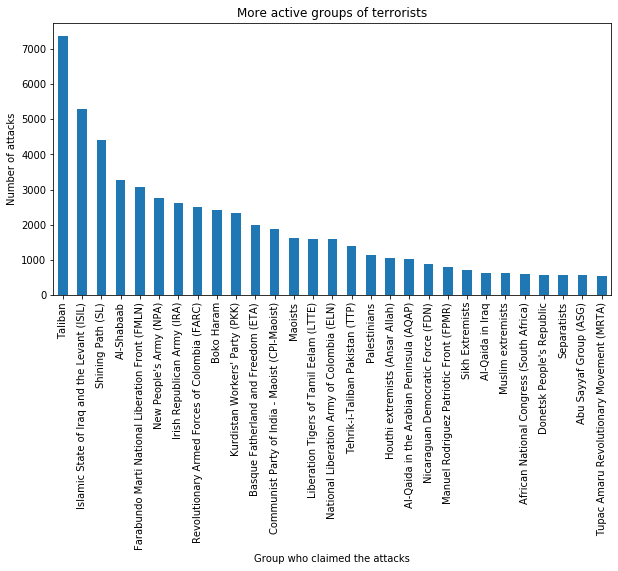

In [32]:
df_count_claim[1:30].plot(kind ='bar', x = 'gname',  legend = False, figsize=(10,5))
plt.ylabel('Number of attacks')
plt.xlabel('Group who claimed the attacks')
plt.title('More active groups of terrorists')

Here we observe the most active terrorist groups in the last 50 years. It would be wise to explore what kind of population was targeted, throught what kind of weapon they are acting...

In [33]:
df_weapon = df_approx[['weaptype1_txt', 'year']]
df_count_weapon = df_weapon.weaptype1_txt.apply(pd.Series).merge(df_weapon, right_index = True, left_index = True) \
            .drop(["weaptype1_txt"], axis = 1) \
            .melt(id_vars = ['year'], value_name = "weaptype") \
            .drop("variable", axis = 1).dropna(subset = ['weaptype'])

In [34]:
df_count_weapon = df_count_weapon.groupby('weaptype').count()
df_count_weapon.reset_index(inplace = True)
df_count_weapon=df_count_weapon.rename(columns={'year': 'count'}).sort_values(by='count', ascending = False)
df_count_weapon.weaptype[11] = 'Vehicle'
df_count_weapon.head(40)

/Users/camilleelleaume/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,weaptype,count
2,Explosives,92684
4,Firearms,63956
10,Unknown,15683
5,Incendiary,12967
6,Melee,5406
1,Chemical,383
7,Other,271
9,Sabotage Equipment,213
11,Vehicle,203
3,Fake Weapons,69


Text(0.5, 1.0, 'More active groups of terrorists')

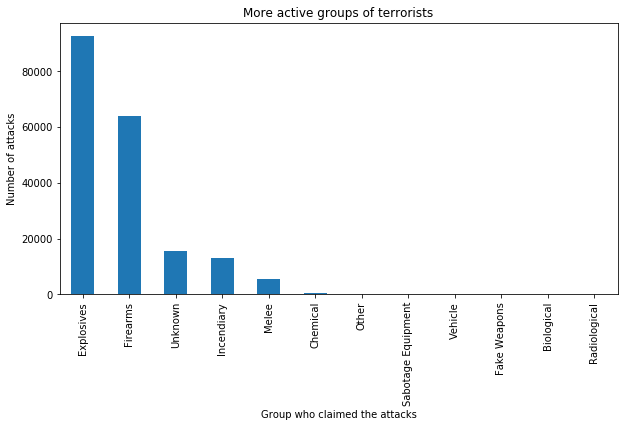

In [35]:
df_count_weapon.plot(kind ='bar', x = 'weaptype',  legend = False, figsize=(10,5))
plt.ylabel('Number of attacks')
plt.xlabel('Group who claimed the attacks')
plt.title('More active groups of terrorists')

Most of attacks use explosive or firearms. It can be intersting to link those type of attacks with wouded or killed vitims. 

## News paper 

### Scrap New York Times articles

We scrap data from New York Times we this funtion. Most of functions are contained in getnytimes.py file. 

In [36]:
from getnytimes import *

def get_store_csv(query, year, output_path):
    '''
    Using the previous fucntions, it takes the query, year and output_path to save
    the articles found by NY Times API into a csv format for later use. 
    '''
    nytimes = get_articles(query, year)
    df_nytimes = pd.DataFrame(nytimes)
    #print(df_nytimes.shape)

    df_nytimes.to_csv(os.path.join(output_path,"NYT"+str(query)+"_"+str(year)+".csv"))
    df_nytimes.head()
    
    return df_nytimes

### All the news dataset cleaning

In [42]:
df1 = pd.read_csv('../../Projet/all-the-news/articles1.csv', header=0)
df2 = pd.read_csv('../../Projet/all-the-news/articles2.csv', header=0)
df3 = pd.read_csv('../../Projet/all-the-news/articles3.csv', header=0)

In [43]:
df = pd.concat([df1, df2, df3], ignore_index=True,join="outer") 
df.drop(columns=["Unnamed: 0"], inplace = True)
df.head()

,id,title,publication,author,date,year,month,url,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [44]:
df_articles= pd.DataFrame({"title": df['title'], 'dates': df['date'],'desc': df['content']})
df_articles=df_articles.drop_duplicates(subset='title').reset_index(drop=True)
df_articles=df_articles.dropna()

In [46]:
nlp = en_core_web_sm.load()
phrase_matcher = PhraseMatcher(nlp.vocab)

Find articles related to terrorisme

In [50]:
#add the new dictionnary
phrases = ['terrorism','mass shooting','attack','bomb','violence','isis','Al-Quaeda','jihad', 'shooting']
patterns = [nlp(text) for text in phrases]
phrase_matcher.add('TERROR', None, *patterns)

In [51]:
processed_article=""
df_span= pd.DataFrame({"title": [], "word_found": []})

for p in  tqdm(df_articles.title[:50000]):
    #article_text += p
    processed_article = p.lower()  
    processed_article = re.sub('[^a-zA-Z]', ' ', processed_article )  
    processed_article = re.sub(r'\s+', ' ', processed_article)
    sentence = nlp (processed_article) 
    matched_phrases = phrase_matcher(sentence)
    
    for match_id, start, end in matched_phrases:
        string_id = nlp.vocab.strings[match_id]  
        span = sentence[start:end]
        spantastic = pd.Series(data={"title" : p ,"word_found": span.text})
        df_span = df_span.append(spantastic, ignore_index=True)
        
df_span.to_pickle("Matched_titles_part1.pkl")

In [52]:
processed_article=""
df_span= pd.DataFrame({"title": [], "word_found": []})

for p in  tqdm(df_articles.title[90000:]):
    processed_article = p.lower()  
    processed_article = re.sub('[^a-zA-Z]', ' ', processed_article )  
    processed_article = re.sub(r'\s+', ' ', processed_article)
    sentence = nlp (processed_article) 
    matched_phrases = phrase_matcher(sentence)
    
    for match_id, start, end in matched_phrases:
        string_id = nlp.vocab.strings[match_id]  
        span = sentence[start:end]
        spantastic = pd.Series(data={"title" : p ,"word_found": span.text})
        df_span = df_span.append(spantastic, ignore_index=True)
        
df_span.to_pickle("Matched_titles_part2.pkl")

In [53]:
#run from here
df_span1 = pd.read_pickle("Matched_titles_part1.pkl")
df_span2 = pd.read_pickle("Matched_titles_part2.pkl")

In [57]:
df_span = pd.concat([df_span1, df_span2], ignore_index=True,join="outer") 
df_words= df.merge(df_span, on = "title", how = 'outer')

At this step, we are going to drop all the NaN cells contained in the word_found columns in order to keep only the titles containing the terrorism subset of words.

In [58]:
df_words=df_words.dropna(subset=['word_found'])
df_words.drop_duplicates().reset_index(inplace=True)

Extract mentioned countries in the content of articles

In [59]:
country=pycountry.countries
def list_country_name():
    """Return a list of ISO 3166-1 Alpha 3 country codes."""
    return [x.name for x in pycountry.countries] 

In [61]:
#retrieving the list of all possible countries (and forcing them to be lower case)
df_countries = pd.Series(list_country_name()).str.lower()

In [62]:
#function to extract the country from a string. as soon as a country is found, it will return the country
def extract_country(text):
    for country in pycountry.countries:
        if country.name in text:
            #print(country.name)
            return [country.name]

In [63]:
#recreate a new dataframe which only has the entries which can be identified as countries
df_country_replace=df_words.loc[(df_words['content'].apply(lambda x: any([k in x for k in df_countries])))]

#make sure that the locations are in the proper format (1st letter capitalized) and stored as string
df_country_replace['locations']=df_country_replace.content.str.title()

#re-indexing the dataframe (get rid of multiple index  of form 0,0,0,1,2,2,2 etc)
df_country_replace=df_country_replace.reset_index(drop=True)

/Users/camilleelleaume/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [64]:
for i, row in df_country_replace.iterrows():
    df_country_replace.at[i,'locations']=extract_country(df_country_replace.loc[i].locations)

In [65]:
#ensure that everything in locations is considered as string, so comparison between the columns is easy.
df_country_replace.locations=df_country_replace.locations.astype(str)
# drop duplicates. based on location, date and headline
df_country_replace=df_country_replace.drop_duplicates(subset=['locations','date','title'], keep='first')

### New York times data base cleaning

In [67]:
df_nyt = pd.read_csv( 'NYT_articles.csv', encoding='ISO-8859-1' )

In [68]:
#cleaning df_nyt and creating a date-type entry for date
df_nyt=df_nyt.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_nyt['date']=pd.to_datetime(df_nyt.date, exact=False, errors = 'coerce')

In [69]:
# forcing th string of locations to be all lowercase and split according to  commas.
df_nyt['locations']=df_nyt.locations.str.lower().str.split(',')

#exploding the locations column to have individual information per row
s=pd.DataFrame({'locations':np.concatenate(df_nyt.locations.values)},index=df_nyt.index.repeat(df_nyt.locations.str.len()))
s=s.join(df_nyt.drop('locations',1),how='left')

In [70]:
#replacing portions of the string
s.locations=s.locations.str.replace('[','')
s.locations=s.locations.str.replace(']','')
s.locations=s.locations.str.replace('(','')
s.locations=s.locations.str.replace(')','')

In [71]:
#recreate a new dataframe which only has the entries which can be identified as countries
df_country_replace_nyt=s.loc[(s['locations'].apply(lambda x: any([k in x for k in df_countries])))]

#make sure that the locations are in the proper format (1st letter capitalized) and stored as string
df_country_replace_nyt.locations=df_country_replace_nyt.locations.str.title()

#re-indexing the dataframe (get rid of multiple index  of form 0,0,0,1,2,2,2 etc)
df_country_replace_nyt=df_country_replace_nyt.reset_index(drop=True)

/Users/camilleelleaume/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [72]:
for i, row in df_country_replace_nyt.iterrows():
    df_country_replace_nyt.at[i,'locations'] = extract_country(df_country_replace_nyt.loc[i].locations)

In [73]:
#ensure that everything in locations is considered as string, so comparison between the columns is easy.
df_country_replace_nyt.locations = df_country_replace_nyt.locations.astype(str)

# drop duplicates. based on location, date and headline
df_country_replace_nyt = df_country_replace_nyt.drop_duplicates(subset=['locations','date','headline'], keep='first')

In [74]:
word_counts = []    
for i in df_country_replace['content']:
    words_in_df = len([token.text for token in nlp(i)if token.is_punct != True])
    word_counts.append(words_in_df)
       
df_country_replace['word_counts'] = word_counts

In [75]:
df_country_replace = df_country_replace.rename(columns={'word_found': 'subjects'})
df_country_replace_nyt = df_country_replace_nyt.rename(columns={'abstract': 'content', \
                                                                'headline': 'title','source':'publication', \
                                                                'word_count':'word_counts'})

In [76]:
df_papers = pd.concat([df_country_replace_nyt, df_country_replace],join="outer")
df_papers.head()

/Users/camilleelleaume/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,author,content,date,desk,id,locations,month,publication,section,snippet,subjects,title,type,url,word_counts,year
0,NaN,b'Sri Lankan officials and Western diplomats l...,1997-10-16 00:00:00,Foreign Desk,nyt://article/2624e325-d28e-5f2e-9586-24a5b5f1...,['Sri Lanka'],NaN,The New York Times,World,b'Sri Lankan officials and Western diplomats l...,"['United States International Relations', 'Bom...",b'Tamil Tigers Are Linked To Fatal Blast In Sr...,News,https://www.nytimes.com/1997/10/16/world/tamil...,585.0,NaN
2,NaN,"b""Thomas L Friedman Op-Ed column on surge in P...",1997-10-16 00:00:00,Editorial Desk,nyt://article/2fd7ea7d-7c04-508b-bb38-14125342...,['Israel'],NaN,The New York Times,Opinion,"b""Thomas L Friedman Op-Ed column on surge in P...",['Assassinations and Attempted Assassinations'...,b'Foreign Affairs; Cover Story',Op-Ed,https://www.nytimes.com/1997/10/16/opinion/for...,755.0,NaN
3,NaN,"b""Thomas L Friedman Op-Ed column on surge in P...",1997-10-16 00:00:00,Editorial Desk,nyt://article/2fd7ea7d-7c04-508b-bb38-14125342...,['Jordan'],NaN,The New York Times,Opinion,"b""Thomas L Friedman Op-Ed column on surge in P...",['Assassinations and Attempted Assassinations'...,b'Foreign Affairs; Cover Story',Op-Ed,https://www.nytimes.com/1997/10/16/opinion/for...,755.0,NaN
4,NaN,"b""Truck bomb that killed 18 people and wounded...",1997-10-17 00:00:00,Foreign Desk,nyt://article/72e8cda8-1d01-5938-97cf-17611283...,['Sri Lanka'],NaN,The New York Times,World,"b""Truck bomb that killed 18 people and wounded...","['Bombs and Explosives', 'Politics and Governm...","b""Bombing's Fallout Adds to the Gloom Hanging ...",News,https://www.nytimes.com/1997/10/17/world/bombi...,563.0,NaN
6,NaN,"b'Libya, apparently encouraged by African and ...",1997-10-19 00:00:00,Foreign Desk,nyt://article/cf251952-3d63-5bc9-a6d2-e0d5f170...,['Libya'],NaN,The New York Times,World,"b'Libya, apparently encouraged by African and ...","['AIRLINES AND AIRPLANES', 'Bombs and Explosiv...",b'Libya Is Reported to Lobby to Settle Pan Am ...,News,https://www.nytimes.com/1997/10/19/world/libya...,569.0,NaN


In [80]:
#counting the number of articles linked to terrorism according to country
df_papers_count = df_papers.groupby('locations')['date'].count().to_frame()
df_papers_count.reset_index(inplace = True)
df_papers_count.rename(columns={'date' : 'number of articles'}, inplace = True)
df_papers_count.locations = df_papers_count.locations.apply(lambda x : ast.literal_eval(str(x))).str[0]
df_papers_count = df_papers_count[1:]
df_papers_count.sort_values(by='number of articles', ascending = False).head()

,locations,number of articles
47,Iraq,467
1,Afghanistan,325
79,Pakistan,268
49,Israel,205
110,United States,195


In [88]:
df_papers_count = set_country_code(df_papers_count, 'locations', dictionary)
plot_map(df_papers_count, gdf, 'number of articles', 160, 'Number of Articles per Country')

Loading BokehJS ...

From this map we can see that the countries that beneficiate from more coverage are the USA, Canada, India and Western Europe. On the other hand, Russia and Sub-Saharan Africa is not covered by our dataset of articles, this might be explained by a complicated geopolitical context.